#### Importing libs and data

In [67]:
import pandas as pd
import seaborn as sns
# Adding the grid lines so the values in the graphs are easier to comprehend 
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px 
import scipy
from scipy.stats import norm
import statsmodels.api as sm 
import pylab as py 
from scipy.stats import ranksums

concatenated_data = pd.DataFrame()

for year in range(2015, 2024):
    filename = f'C:/Users/Admin/Desktop/WHR_{year}.csv'
    data = pd.read_csv(filename)
    data['year'] = year
    concatenated_data = pd.concat([concatenated_data, data], ignore_index=True)
    
concatenated_data.to_csv('WHR_concatenated.csv', index=False)
concatenated_data.to_csv('WHR_concatenated_with_year.csv', index=False)
data= pd.read_csv('C:/Users/Admin/Desktop/WHR_concatenated_with_year.csv')

#### Cleaning data

In [68]:
#check for any NULLs in the data and see data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       1367 non-null   object 
 1   region                        1367 non-null   object 
 2   happiness_score               1367 non-null   float64
 3   gdp_per_capita                1367 non-null   float64
 4   social_support                1367 non-null   float64
 5   healthy_life_expectancy       1366 non-null   float64
 6   freedom_to_make_life_choices  1367 non-null   float64
 7   generosity                    1367 non-null   float64
 8   perceptions_of_corruption     1366 non-null   float64
 9   year                          1367 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 106.9+ KB


In [69]:
data.isna().sum()

country                         0
region                          0
happiness_score                 0
gdp_per_capita                  0
social_support                  0
healthy_life_expectancy         1
freedom_to_make_life_choices    0
generosity                      0
perceptions_of_corruption       1
year                            0
dtype: int64

In [70]:
# Fill missing values with the average value
data['perceptions_of_corruption'] = data.groupby('country')['perceptions_of_corruption'].transform(lambda x: x.fillna(x.mean()))
data['healthy_life_expectancy'] = data.groupby('region')['healthy_life_expectancy'].transform(lambda x: x.fillna(x.mean()))

In [71]:
data.isna().sum()

country                         0
region                          0
happiness_score                 0
gdp_per_capita                  0
social_support                  0
healthy_life_expectancy         0
freedom_to_make_life_choices    0
generosity                      0
perceptions_of_corruption       0
year                            0
dtype: int64

#### Проверка данных на нормальность

In [72]:
#Shapiro Wilk test
scipy.stats.shapiro(data['happiness_score'])

ShapiroResult(statistic=0.9902408123016357, pvalue=6.777220562526054e-08)

Значение p_value = 0.000000068 говорит о том, что мы можем отвергнуть нулевую гипотезу H_0 о том, что данные распределены равномерно. **Наши данные распределены не нормально**.

In [73]:
len(data['happiness_score'])

1367

Число наблюдений - 1367. Поэтому, воспользуем еще одним способом проверки на "нормальность" и посмотроим гистограмму и QQ-plot.

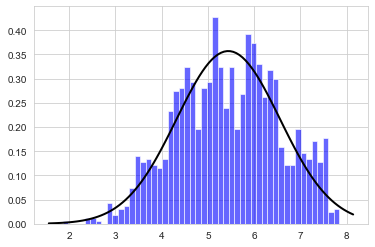

In [74]:
mu, std = norm.fit(data['happiness_score']) 
plt.hist(data['happiness_score'], bins=50, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

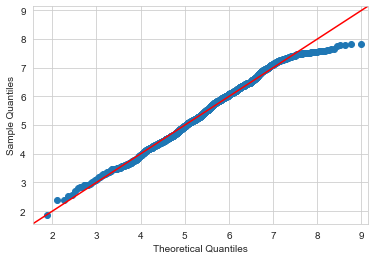

In [75]:
data_points = data['happiness_score']    
sm.qqplot(data_points, line ='45', loc=mu, scale=std) 
py.show()

Согласно гистограмме и qq plot, наши данные очень даже близки к нормальному распределению. Однако, тест Шапиро Уилка показал очень малое значение p_value.

In [76]:
data_artificial = scipy.stats.norm.rvs(loc=mu, scale=std, size=500)
data_artificial = sorted(data_artificial)[:460]
scipy.stats.shapiro(data_artificial)

ShapiroResult(statistic=0.9702976942062378, pvalue=4.843730749826136e-08)

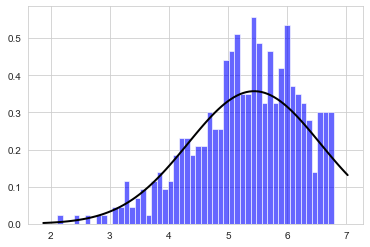

In [77]:
plt.hist(data_artificial, bins=50, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

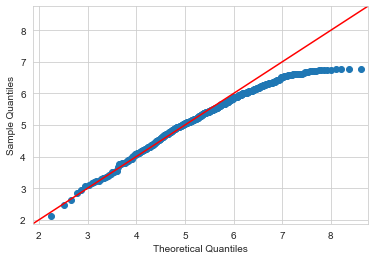

In [78]:
data_points = np.array(data_artificial)
sm.qqplot(data_points, line ='45', loc=mu, scale=std) 
plt.show()

Сгенерировав выборку с таким же средним значением и дисперсией и обрезав ее правый конец, мы видим, что наши данные были бы быть распределены нормально, если бы мы имели данные после 8.

#### Mann Whitney U test

Воздействие, от которого мы будем анализировать эффект - пандемия Covid - 19. Разделим данные на 2 части: до 2019 года включительно и после 2019 года (начиная с 2020 года).

H_0: mu_1 = mu_2
Распределения двух популяций одинаковые

H_1: mu_1 < mu_2
Распределение популяции 1 находится левее распределения популяции 2

H_2: mu_1 > mu_2
Распределение популяции 1 находится правее распределения популяции 2

In [93]:
sample1 = data[data['year'] < 2020]['happiness_score']
sample2 = data[data['year'] > 2019]['happiness_score']
print(ranksums(sample1, sample2))
print('mu_1 =', sample1.mean().round(2), 'mu_2 =', sample2.mean().round(2))

RanksumsResult(statistic=-2.6190161021066882, pvalue=0.008818378490046666)
mu_1 = 5.38 mu_2 = 5.52


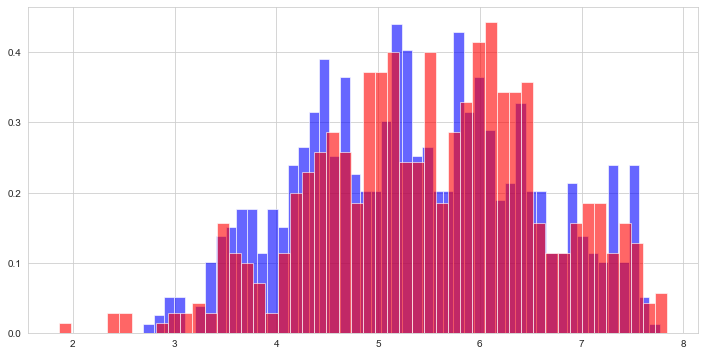

In [94]:
fig, ax = plt.subplots(figsize = (12, 6))
plt.hist(sample1, bins=50, density=True, alpha=0.6, color='b')
plt.hist(sample2, bins=50, density=True, alpha=0.6, color='r')
plt.show()

Поскольку значение p_value меньше уровня значимости (0,0088 < 0,05), мы отклоняем H_0 и принимаем H_1. То есть, можно сказать, что люди во всем мире стали счастливее после пандемии Covid-19. 

In [95]:
sample1 = data[data['year'] < 2020]['gdp_per_capita']
sample2 = data[data['year'] > 2019]['gdp_per_capita']
print(ranksums(sample1, sample2))
print('mu_1 =', sample1.mean().round(2), 'mu_2 =', sample2.mean().round(2))

RanksumsResult(statistic=-9.081291379189985, pvalue=1.0729416888703242e-19)
mu_1 = 0.92 mu_2 = 1.16


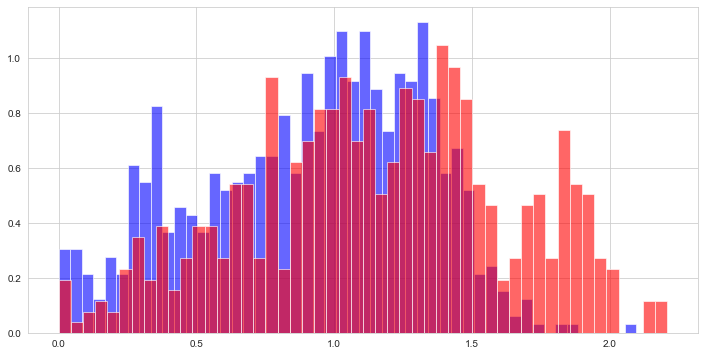

In [96]:
fig, ax = plt.subplots(figsize = (12, 6))
plt.hist(sample1, bins=50, density=True, alpha=0.6, color='b')
plt.hist(sample2, bins=50, density=True, alpha=0.6, color='r')
plt.show()

Поскольку значение p_value меньше уровня значимости (1.07e-19 < 0,05), мы отклоняем H_0 и принимаем H_1. Это говорит о том, что в среднем показатель ВВП вырос по всему миру.

In [97]:
sample1 = data[data['year'] < 2020]['social_support']
sample2 = data[data['year'] > 2019]['social_support']
print(ranksums(sample1, sample2))
print('mu_1 =', sample1.mean().round(2), 'mu_2 =', sample2.mean().round(2))

RanksumsResult(statistic=4.521709456112925, pvalue=6.134221961301761e-06)
mu_1 = 1.08 mu_2 = 1.0


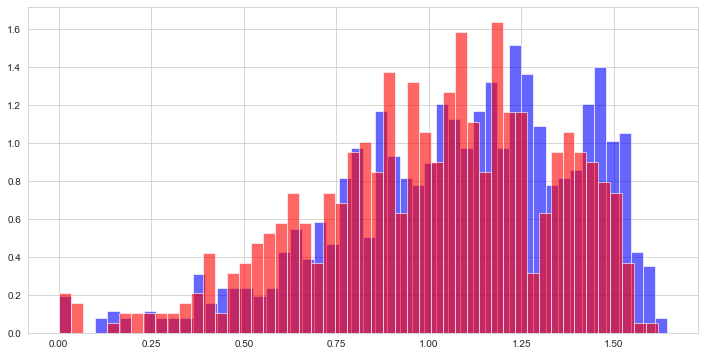

In [98]:
fig, ax = plt.subplots(figsize = (12, 6))
plt.hist(sample1, bins=50, density=True, alpha=0.6, color='b')
plt.hist(sample2, bins=50, density=True, alpha=0.6, color='r')
plt.show()

Поскольку значение p_value меньше уровня значимости (6.13e-06 < 0,05), мы отклоняем H_0 и принимаем H_2. Это говорит о том, что в среднем люди чувствуют поддержку друг друга меньше.

In [99]:
sample1 = data[data['year'] < 2020]['healthy_life_expectancy']
sample2 = data[data['year'] > 2019]['healthy_life_expectancy']
print(ranksums(sample1, sample2))
print('mu_1 =', sample1.mean().round(2), 'mu_2 =', sample2.mean().round(2))

RanksumsResult(statistic=5.6861320327177385, pvalue=1.2994894231823264e-08)
mu_1 = 0.61 mu_2 = 0.55


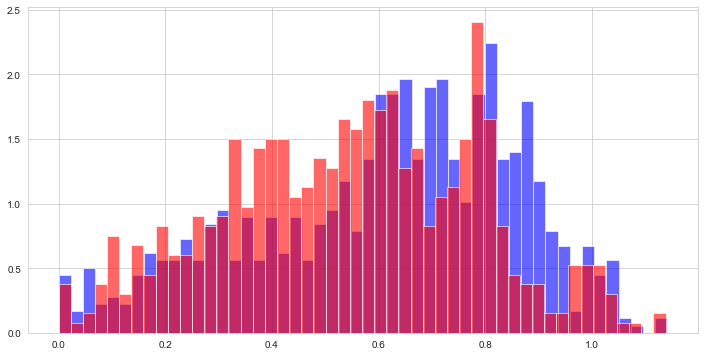

In [100]:
fig, ax = plt.subplots(figsize = (12, 6))
plt.hist(sample1, bins=50, density=True, alpha=0.6, color='b')
plt.hist(sample2, bins=50, density=True, alpha=0.6, color='r')
plt.show()

Поскольку значение p_value меньше уровня значимости (1.3e-08 < 0,05), мы отклоняем H_0 и принимаем H_2. Это говорит о том, что в среднем большинство людей стали менее физически и психически здоровы.

In [105]:
sample1 = data[data['year'] < 2020]['freedom_to_make_life_choices']
sample2 = data[data['year'] > 2019]['freedom_to_make_life_choices']
print(ranksums(sample1, sample2))
print('mu_1 =', sample1.mean().round(2), 'mu_2 =', sample2.mean().round(2))

RanksumsResult(statistic=-11.0188800226842, pvalue=3.098907140606842e-28)
mu_1 = 0.41 mu_2 = 0.5


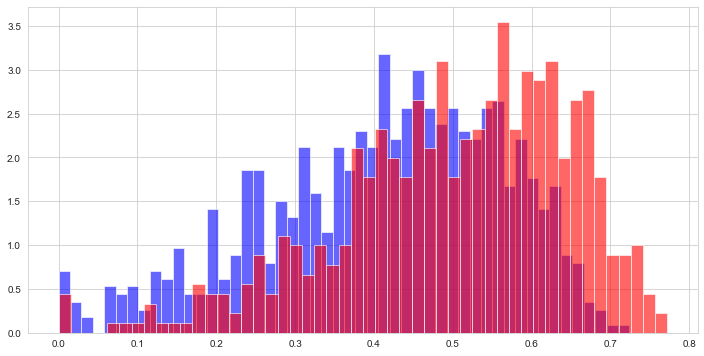

In [106]:
fig, ax = plt.subplots(figsize = (12, 6))
plt.hist(sample1, bins=50, density=True, alpha=0.6, color='b')
plt.hist(sample2, bins=50, density=True, alpha=0.6, color='r')
plt.show()

Поскольку значение p_value меньше уровня значимости (3.10e-28 < 0,05), мы отклоняем H_0 и принимаем H_1. Это говорит о том, что в среднем людям стало доступно больше возможностей. Вероятно, это может быть связано с ростом числа онлайн образовательных платформ, возможностью работать онлайн и т.д.

In [107]:
sample1 = data[data['year'] < 2020]['generosity']
sample2 = data[data['year'] > 2019]['generosity']
print(ranksums(sample1, sample2))
print('mu_1 =', sample1.mean().round(2), 'mu_2 =', sample2.mean().round(2))

RanksumsResult(statistic=8.178306527003043, pvalue=2.8786073259821133e-16)
mu_1 = 0.22 mu_2 = 0.17


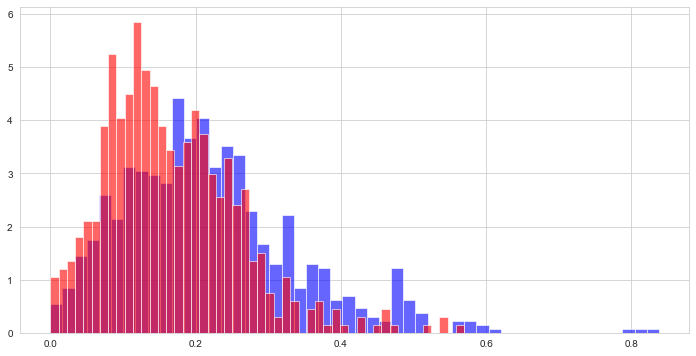

In [108]:
fig, ax = plt.subplots(figsize = (12, 6))
plt.hist(sample1, bins=50, density=True, alpha=0.6, color='b')
plt.hist(sample2, bins=50, density=True, alpha=0.6, color='r')
plt.show()

Поскольку значение p_value меньше уровня значимости (2.88e-16 < 0,05), мы отклоняем H_0 и принимаем H_2. Это говорит о том, что в среднем население Земли стало менее благотворительным.

In [109]:
sample1 = data[data['year'] < 2020]['perceptions_of_corruption']
sample2 = data[data['year'] > 2019]['perceptions_of_corruption']
print(ranksums(sample1, sample2))
print('mu_1 =', sample1.mean().round(2), 'mu_2 =', sample2.mean().round(2))

RanksumsResult(statistic=-2.484835405623151, pvalue=0.012961134622141978)
mu_1 = 0.13 mu_2 = 0.14


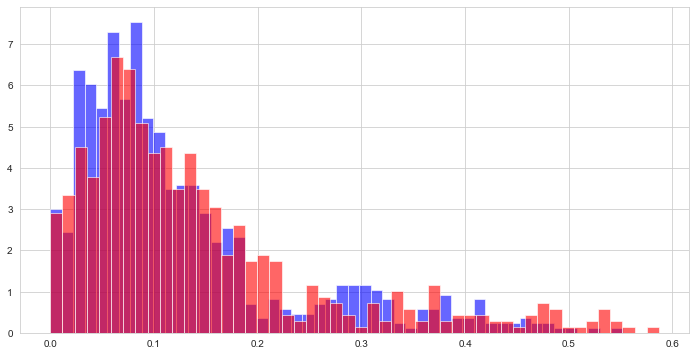

In [110]:
fig, ax = plt.subplots(figsize = (12, 6))
plt.hist(sample1, bins=50, density=True, alpha=0.6, color='b')
plt.hist(sample2, bins=50, density=True, alpha=0.6, color='r')
plt.show()

Поскольку значение p_value меньше уровня значимости (0.013 < 0,05), мы отклоняем H_0 и принимаем H_1. Это говорит о том, что в среднем по миру люди стали сильнее замечать коррупцию в разных организациях. Хочется заметить, что средние значения двух популяций различаются несильно и значение p_value не значительно ниже уровня значимости (оно имеет тот же порядок, в то время как при проверке других показателей были различия в 10+ порядков).